## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [12]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [13]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

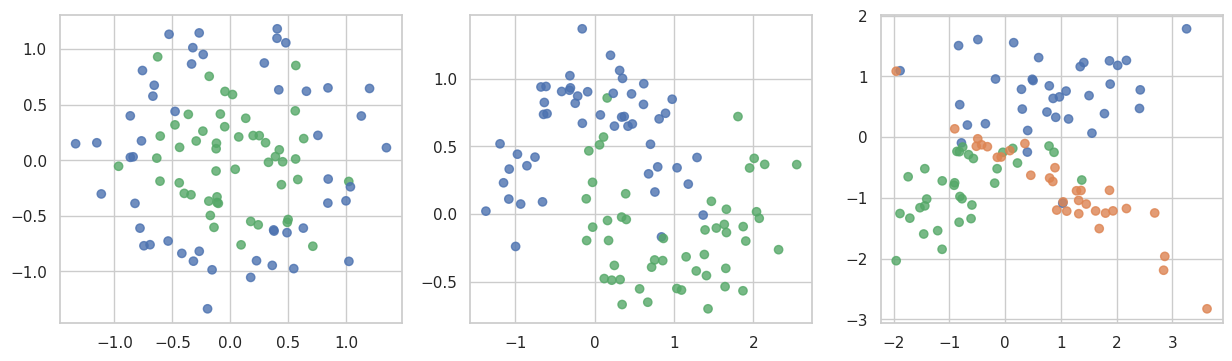

In [14]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [15]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

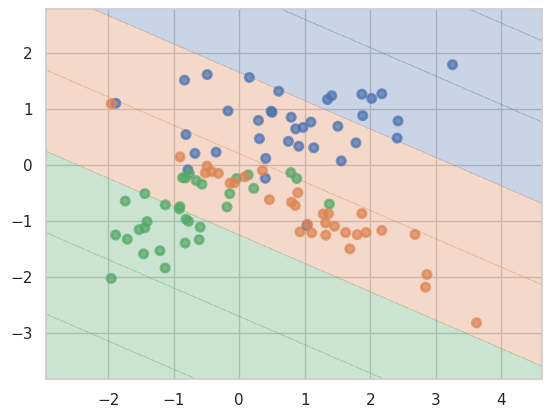

In [16]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Dataset 1:
  Train accuracy: 1.0000
  Test accuracy:  0.7000
  Overfit (train - test): 0.3000

Dataset 2:
  Train accuracy: 1.0000
  Test accuracy:  0.9333
  Overfit (train - test): 0.0667

Dataset 3:
  Train accuracy: 1.0000
  Test accuracy:  0.6667
  Overfit (train - test): 0.3333



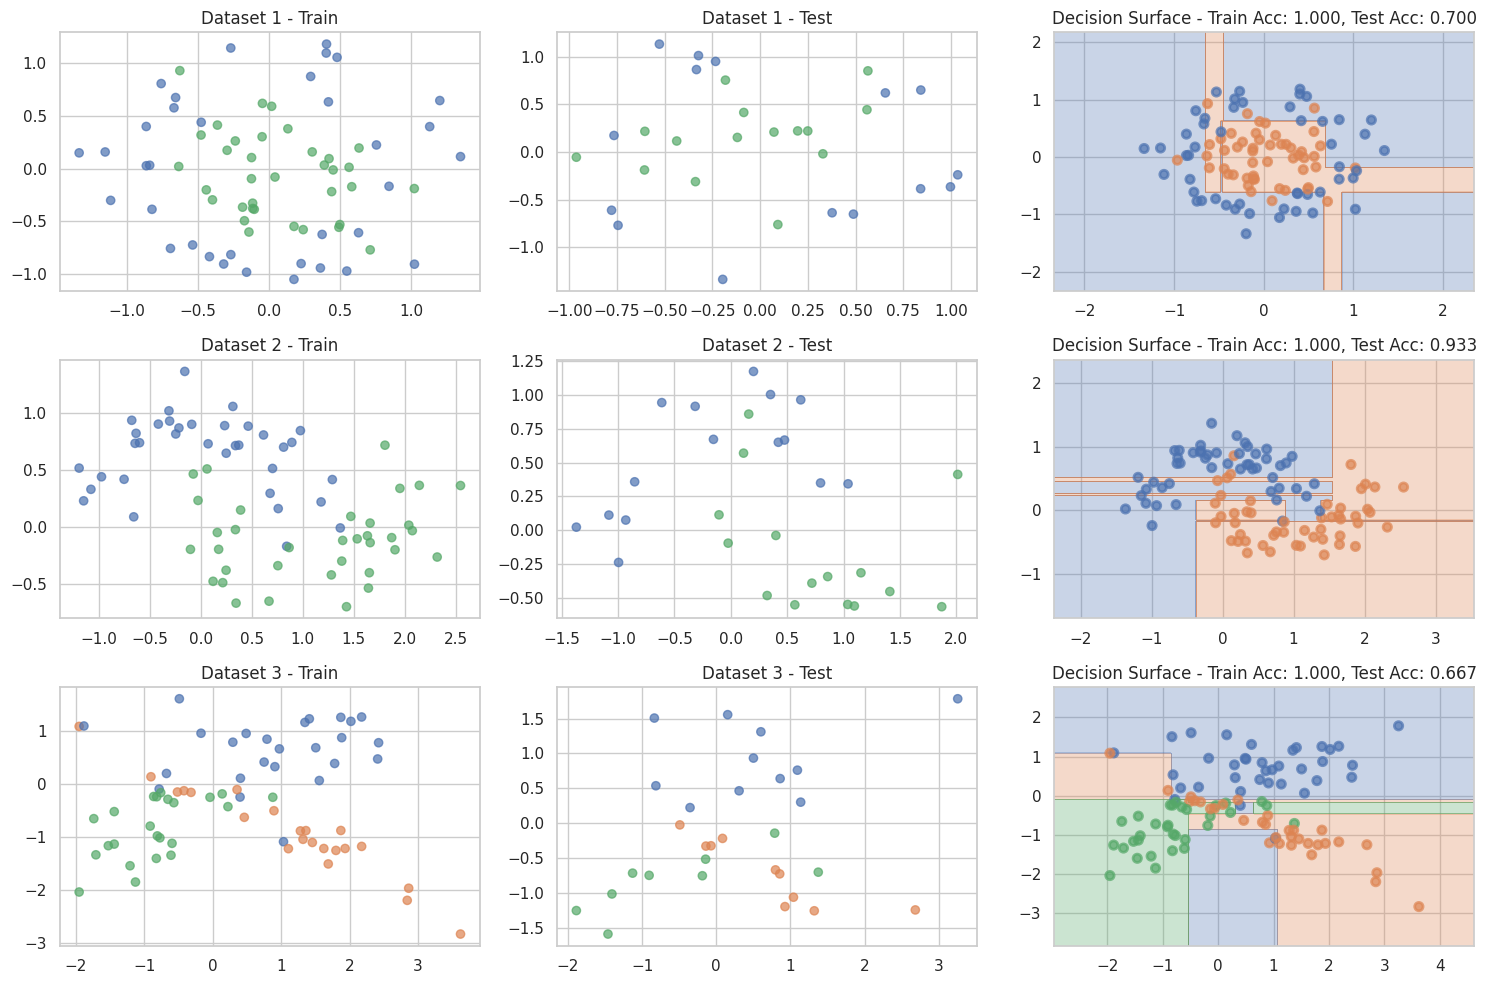

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 10))

for i, (X, y) in enumerate(datasets):
    # Разбиваем на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Обучаем дерево
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    # Считаем accuracy
    train_acc = accuracy_score(y_train, tree.predict(X_train))
    test_acc = accuracy_score(y_test, tree.predict(X_test))

    # Рисуем
    plt.subplot(3, 3, i*3 + 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, alpha=0.7)
    plt.title(f'Dataset {i+1} - Train')

    plt.subplot(3, 3, i*3 + 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, alpha=0.7)
    plt.title(f'Dataset {i+1} - Test')

    plt.subplot(3, 3, i*3 + 3)
    plot_surface(tree, X, y)
    plt.title(f'Decision Surface - Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}')

    # Вывод accuracy
    print(f'Dataset {i+1}:')
    print(f'  Train accuracy: {train_acc:.4f}')
    print(f'  Test accuracy:  {test_acc:.4f}')
    print(f'  Overfit (train - test): {train_acc - test_acc:.4f}')
    print()

plt.tight_layout()
plt.show()

__Ответ:__

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


Датасет 1


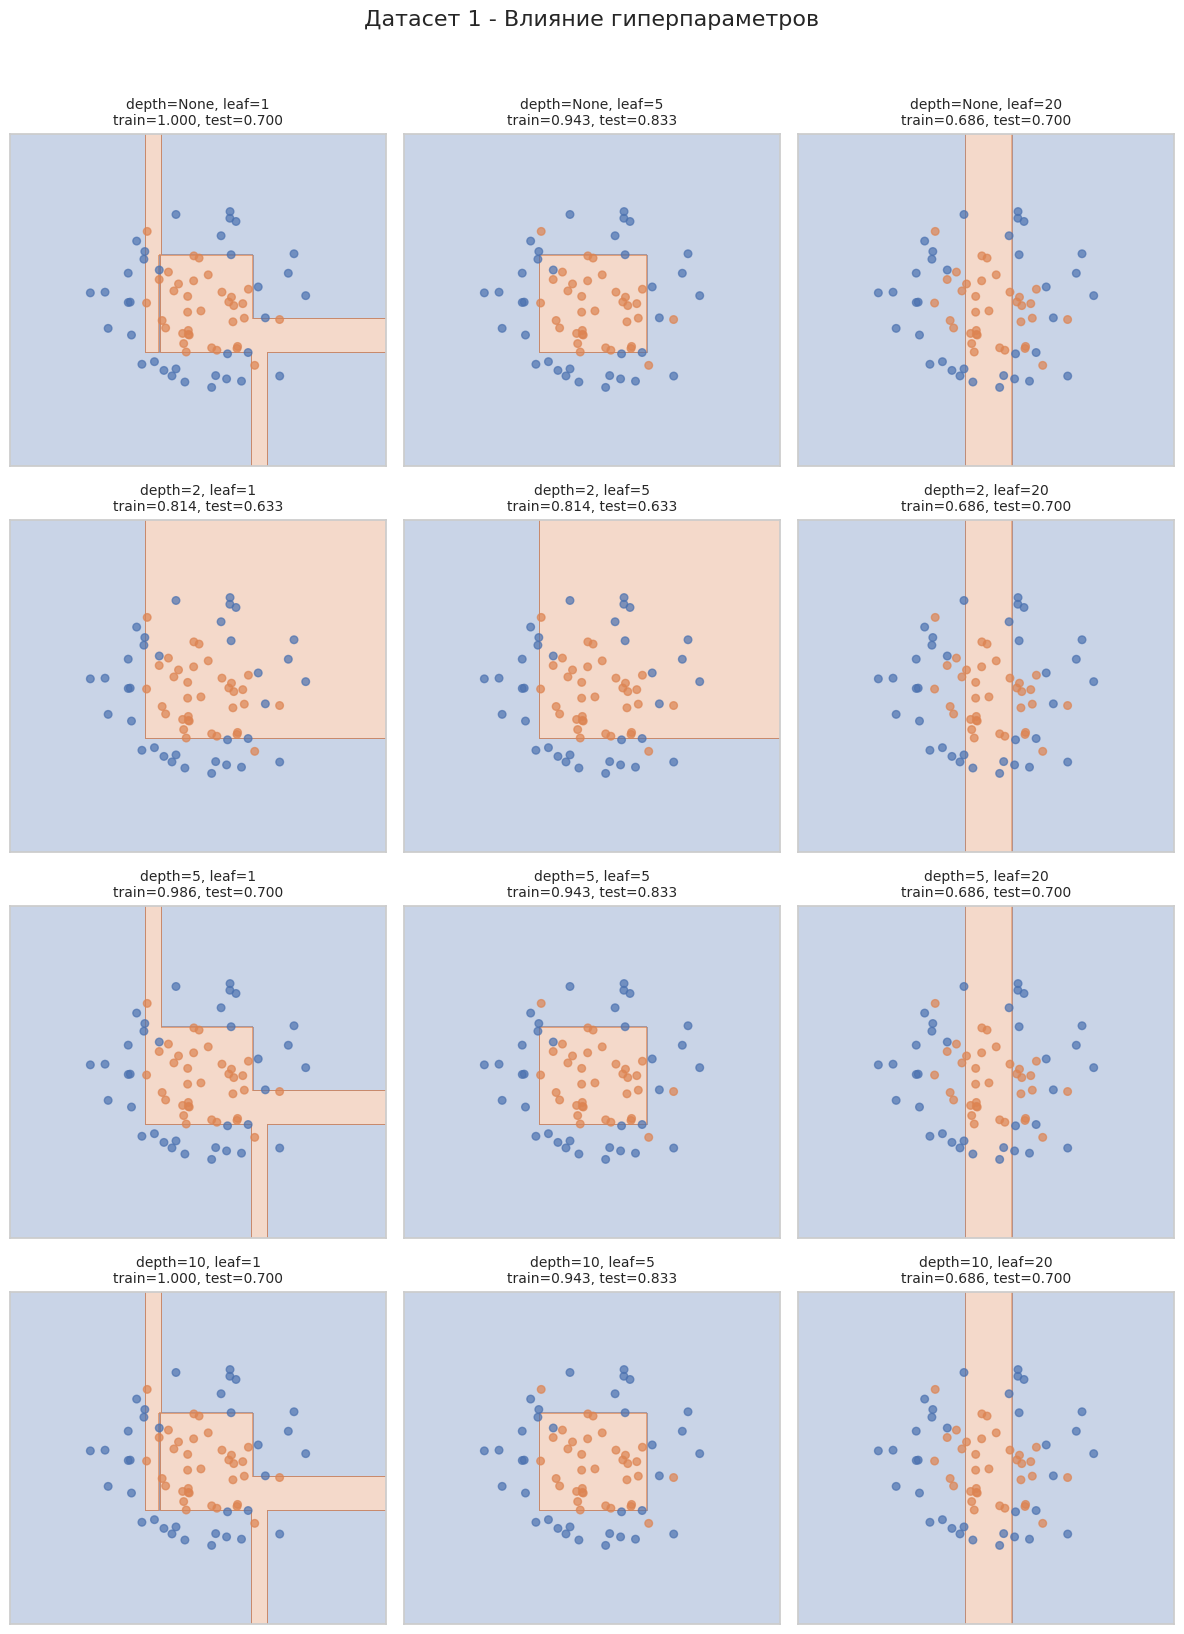


Анализ переобучения (train - test):
  depth=None, leaf= 1: train=1.000, test=0.700, overfit=0.300
  depth=None, leaf= 5: train=0.943, test=0.833, overfit=0.110
  depth=None, leaf=20: train=0.686, test=0.700, overfit=-0.014
  depth=2   , leaf= 1: train=0.814, test=0.633, overfit=0.181
  depth=2   , leaf= 5: train=0.814, test=0.633, overfit=0.181
  depth=2   , leaf=20: train=0.686, test=0.700, overfit=-0.014
  depth=5   , leaf= 1: train=0.986, test=0.700, overfit=0.286
  depth=5   , leaf= 5: train=0.943, test=0.833, overfit=0.110
  depth=5   , leaf=20: train=0.686, test=0.700, overfit=-0.014
  depth=10  , leaf= 1: train=1.000, test=0.700, overfit=0.300
  depth=10  , leaf= 5: train=0.943, test=0.833, overfit=0.110
  depth=10  , leaf=20: train=0.686, test=0.700, overfit=-0.014

Датасет 2


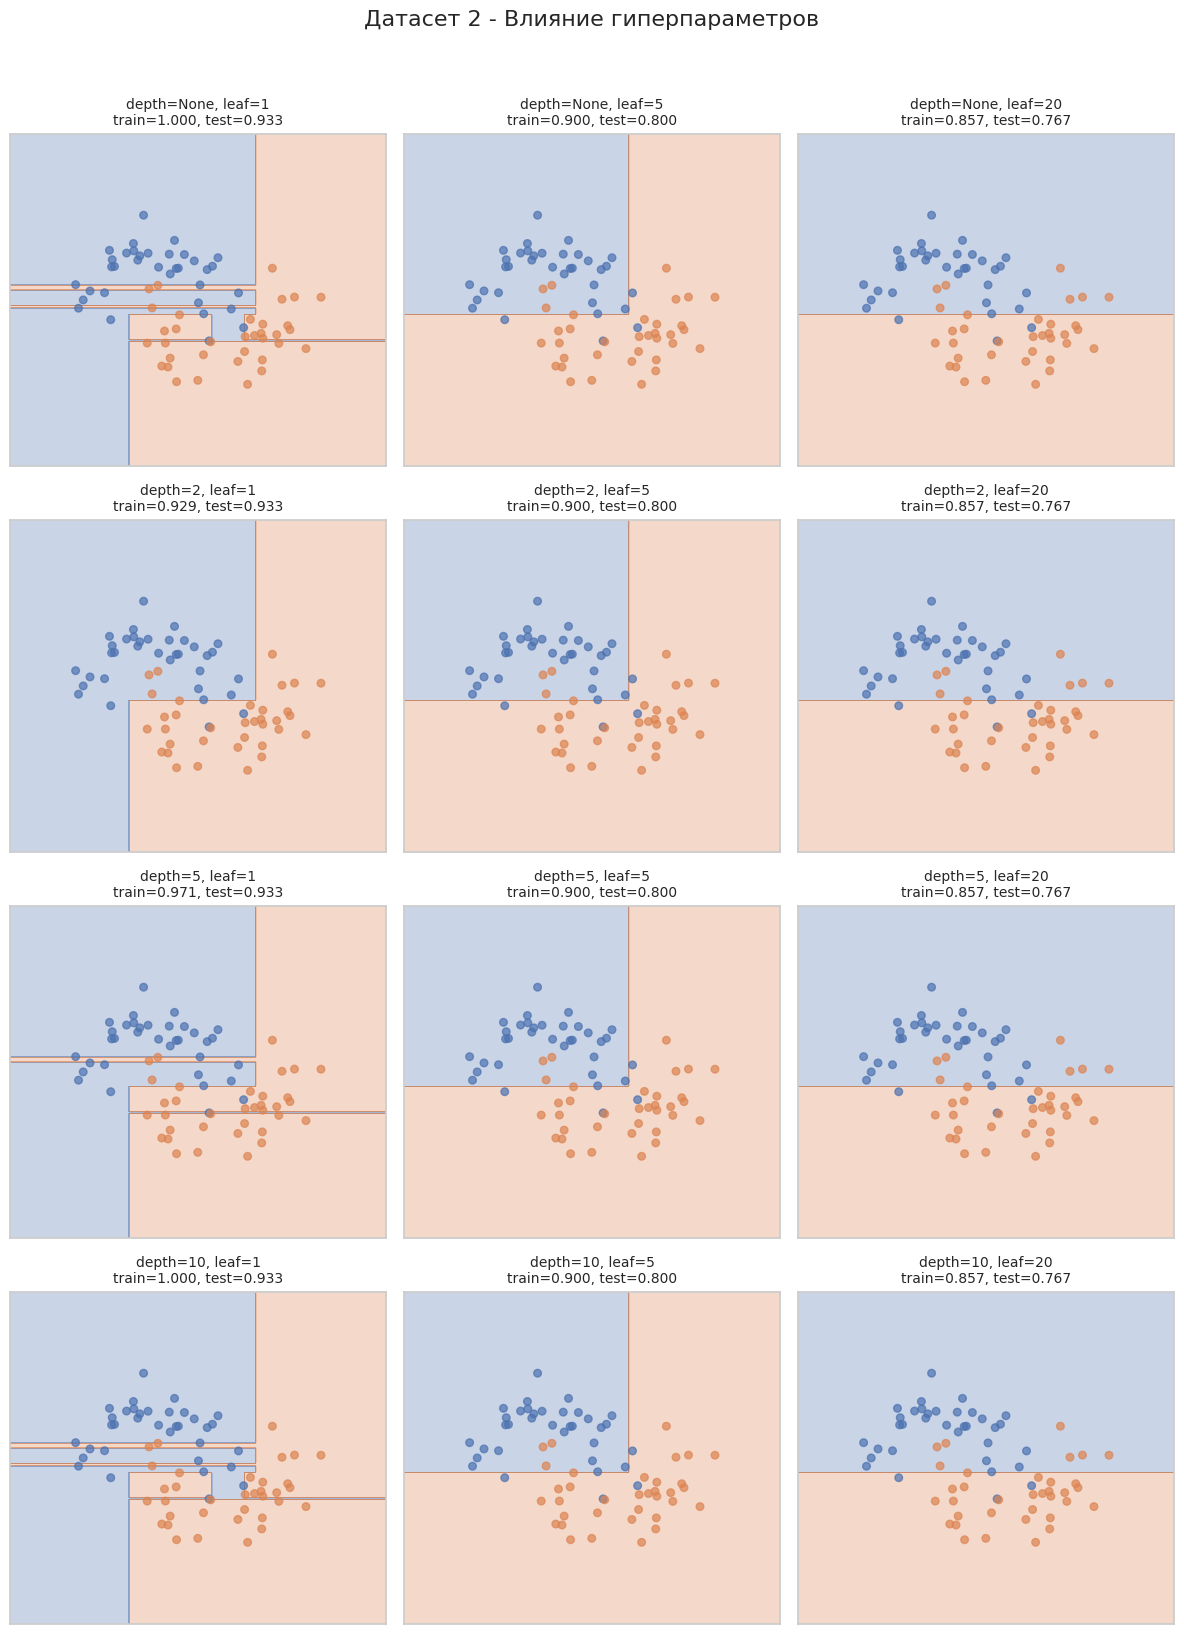


Анализ переобучения (train - test):
  depth=None, leaf= 1: train=1.000, test=0.933, overfit=0.067
  depth=None, leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=None, leaf=20: train=0.857, test=0.767, overfit=0.090
  depth=2   , leaf= 1: train=0.929, test=0.933, overfit=-0.005
  depth=2   , leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=2   , leaf=20: train=0.857, test=0.767, overfit=0.090
  depth=5   , leaf= 1: train=0.971, test=0.933, overfit=0.038
  depth=5   , leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=5   , leaf=20: train=0.857, test=0.767, overfit=0.090
  depth=10  , leaf= 1: train=1.000, test=0.933, overfit=0.067
  depth=10  , leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=10  , leaf=20: train=0.857, test=0.767, overfit=0.090

Датасет 3


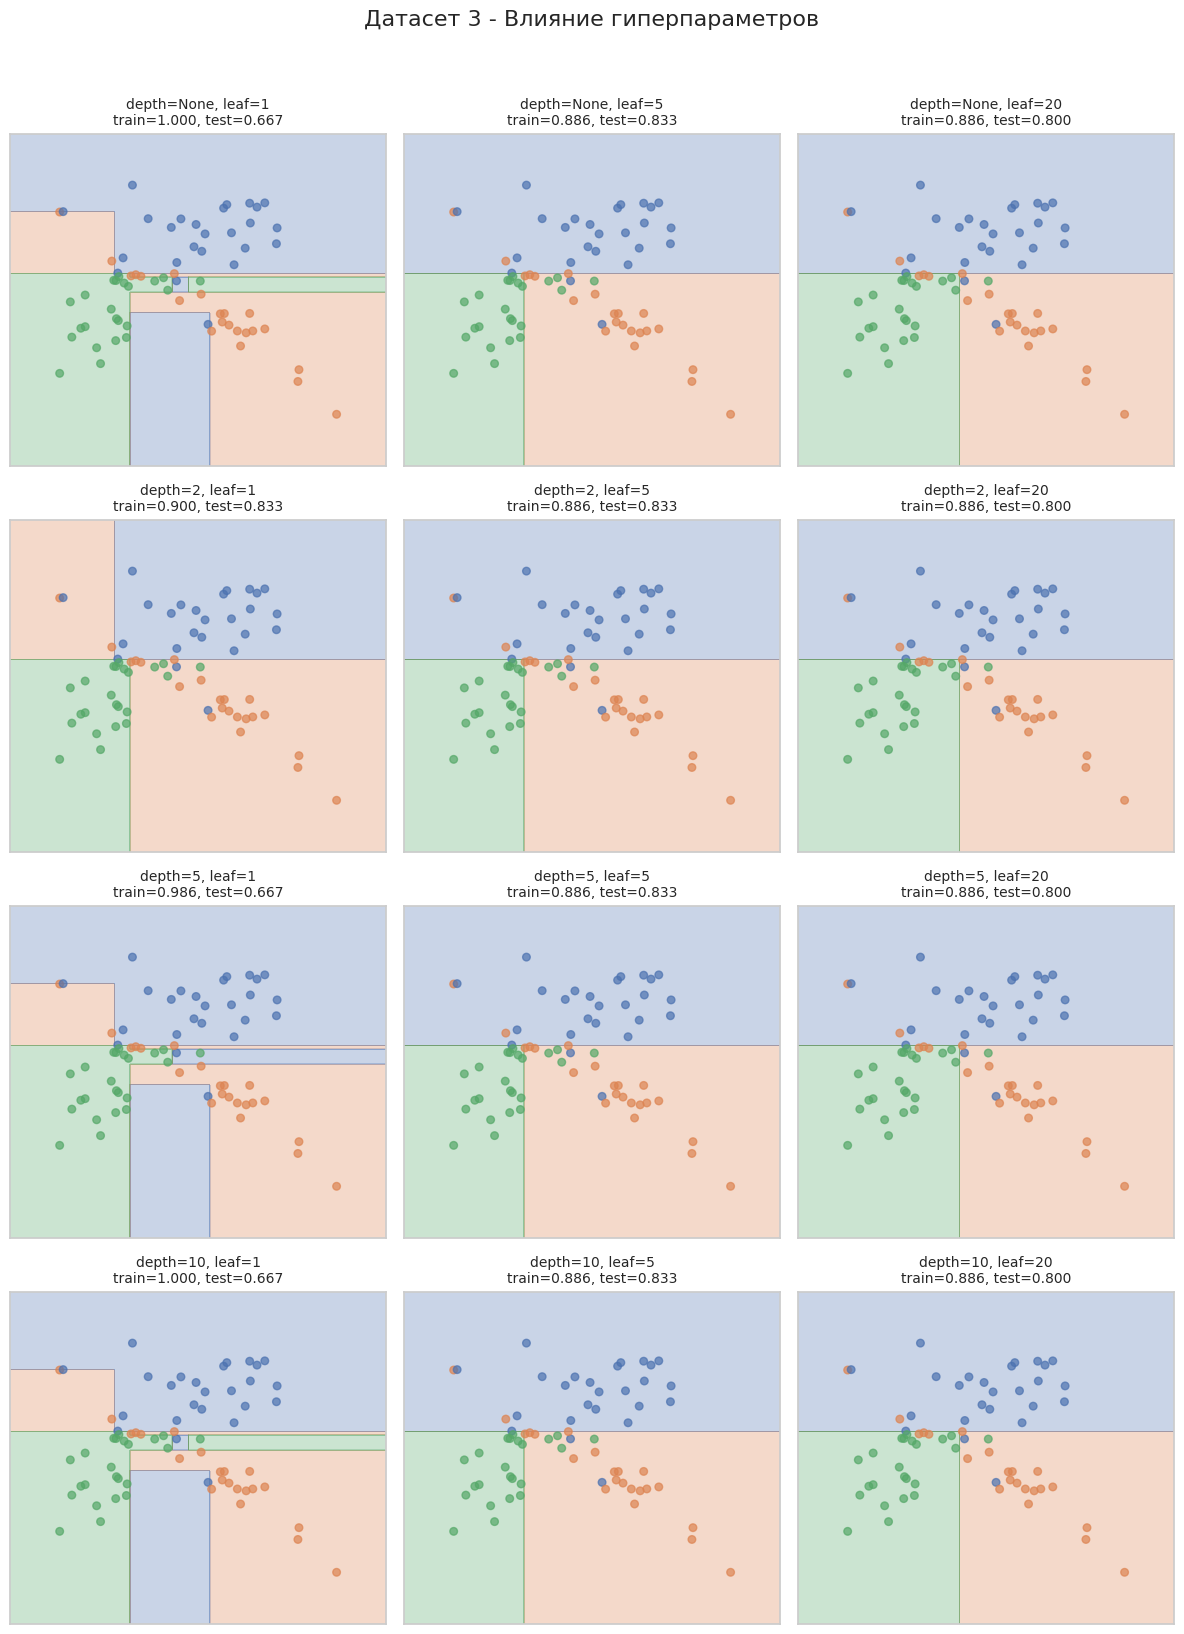


Анализ переобучения (train - test):
  depth=None, leaf= 1: train=1.000, test=0.667, overfit=0.333
  depth=None, leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=None, leaf=20: train=0.886, test=0.800, overfit=0.086
  depth=2   , leaf= 1: train=0.900, test=0.833, overfit=0.067
  depth=2   , leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=2   , leaf=20: train=0.886, test=0.800, overfit=0.086
  depth=5   , leaf= 1: train=0.986, test=0.667, overfit=0.319
  depth=5   , leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=5   , leaf=20: train=0.886, test=0.800, overfit=0.086
  depth=10  , leaf= 1: train=1.000, test=0.667, overfit=0.333
  depth=10  , leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=10  , leaf=20: train=0.886, test=0.800, overfit=0.086


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Функция plot_surface
def plot_surface(clf, X, y, ax):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.7,
               edgecolors=np.array(palette)[y], linewidths=1, s=30)
    ax.set_xticks([])
    ax.set_yticks([])

# Параметры для перебора
max_depths = [None, 2, 5, 10]
min_samples_leaves = [1, 5, 20]

# Фиксируем разбиение для каждого датасета
random_state_split = 42

# Перебор и визуализация
for dataset_idx, (X, y) in enumerate(datasets):
    print(f"\n{'='*60}")
    print(f"Датасет {dataset_idx+1}")
    print('='*60)

    # Фиксированное разбиение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state_split, stratify=y
    )

    # Создаём фигуру для этого датасета
    n_rows = len(max_depths)
    n_cols = len(min_samples_leaves)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    fig.suptitle(f'Датасет {dataset_idx+1} - Влияние гиперпараметров', fontsize=16, y=1.02)

    for i, max_depth in enumerate(max_depths):
        for j, min_samples_leaf in enumerate(min_samples_leaves):
            # Обучаем дерево с текущими гиперпараметрами
            tree = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            tree.fit(X_train, y_train)

            # Считаем accuracy
            train_acc = accuracy_score(y_train, tree.predict(X_train))
            test_acc = accuracy_score(y_test, tree.predict(X_test))

            # Визуализация
            ax = axes[i, j]
            plot_surface(tree, X_train, y_train, ax)

            # Подпись
            depth_str = 'None' if max_depth is None else str(max_depth)
            title = f"depth={depth_str}, leaf={min_samples_leaf}\ntrain={train_acc:.3f}, test={test_acc:.3f}"
            ax.set_title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Анализ для этого датасета
    print("\nАнализ переобучения (train - test):")
    for max_depth in max_depths:
        for min_samples_leaf in min_samples_leaves:
            tree = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            tree.fit(X_train, y_train)
            train_acc = accuracy_score(y_train, tree.predict(X_train))
            test_acc = accuracy_score(y_test, tree.predict(X_test))
            overfit = train_acc - test_acc
            depth_str = 'None' if max_depth is None else str(max_depth)
            print(f"  depth={depth_str:4s}, leaf={min_samples_leaf:2d}: "
                  f"train={train_acc:.3f}, test={test_acc:.3f}, overfit={overfit:.3f}")

__Ответ:__
1. Как меняется разделяющая поверхность с изменением гиперпараметров?

С увеличением max_depth поверхность становится сложнее, "рванее", появляются мелкие изгибы.

С увеличением min_samples_leaf поверхность сглаживается, становится более регулярной.

Комбинация: при малой глубине и большом min_samples_leaf границы почти прямые (вертикальные/горизонтальные), при большой глубине и малом min_samples_leaf — переусложнённые.

2. Как меняется обобщающая способность?

Маленькая глубина → недообучение (train и test accuracy низкие).

Большая глубина без регуляризации → переобучение (train accuracy ~1.0, test низкая).

Оптимальные параметры (глубина 5-10, min_samples_leaf 5-20) → максимальная test accuracy.
3. Почему так происходит?

Из bias-variance decomposition:

Малая глубина → высокий bias (недостаточная сложность модели).

Большая глубина → низкий bias, но высокий variance (модель слишком чувствительна к шуму).

min_samples_leaf уменьшает variance, ограничивая детализацию.

4. Одинаково ли изменение для разных датасетов?

Нет, по-разному:

Circles (сложный): нужна достаточная глубина для аппроксимации окружностей, но легко переобучается.

Moons (средний): оптимальная глубина меньше.

Classification (простой): хорошо работает даже с небольшими деревьями, переобучение слабее.

Вывод: Оптимальные гиперпараметры зависят от сложности данных. Простые данные требуют меньше регуляризации, сложные — больше, но с сохранением достаточной глубины для нелинейных зависимостей.

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


Распаковываем архив...
Архив распакован
Данные успешно загружены. Размер: (8124, 23)

Первые 5 строк:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring ve

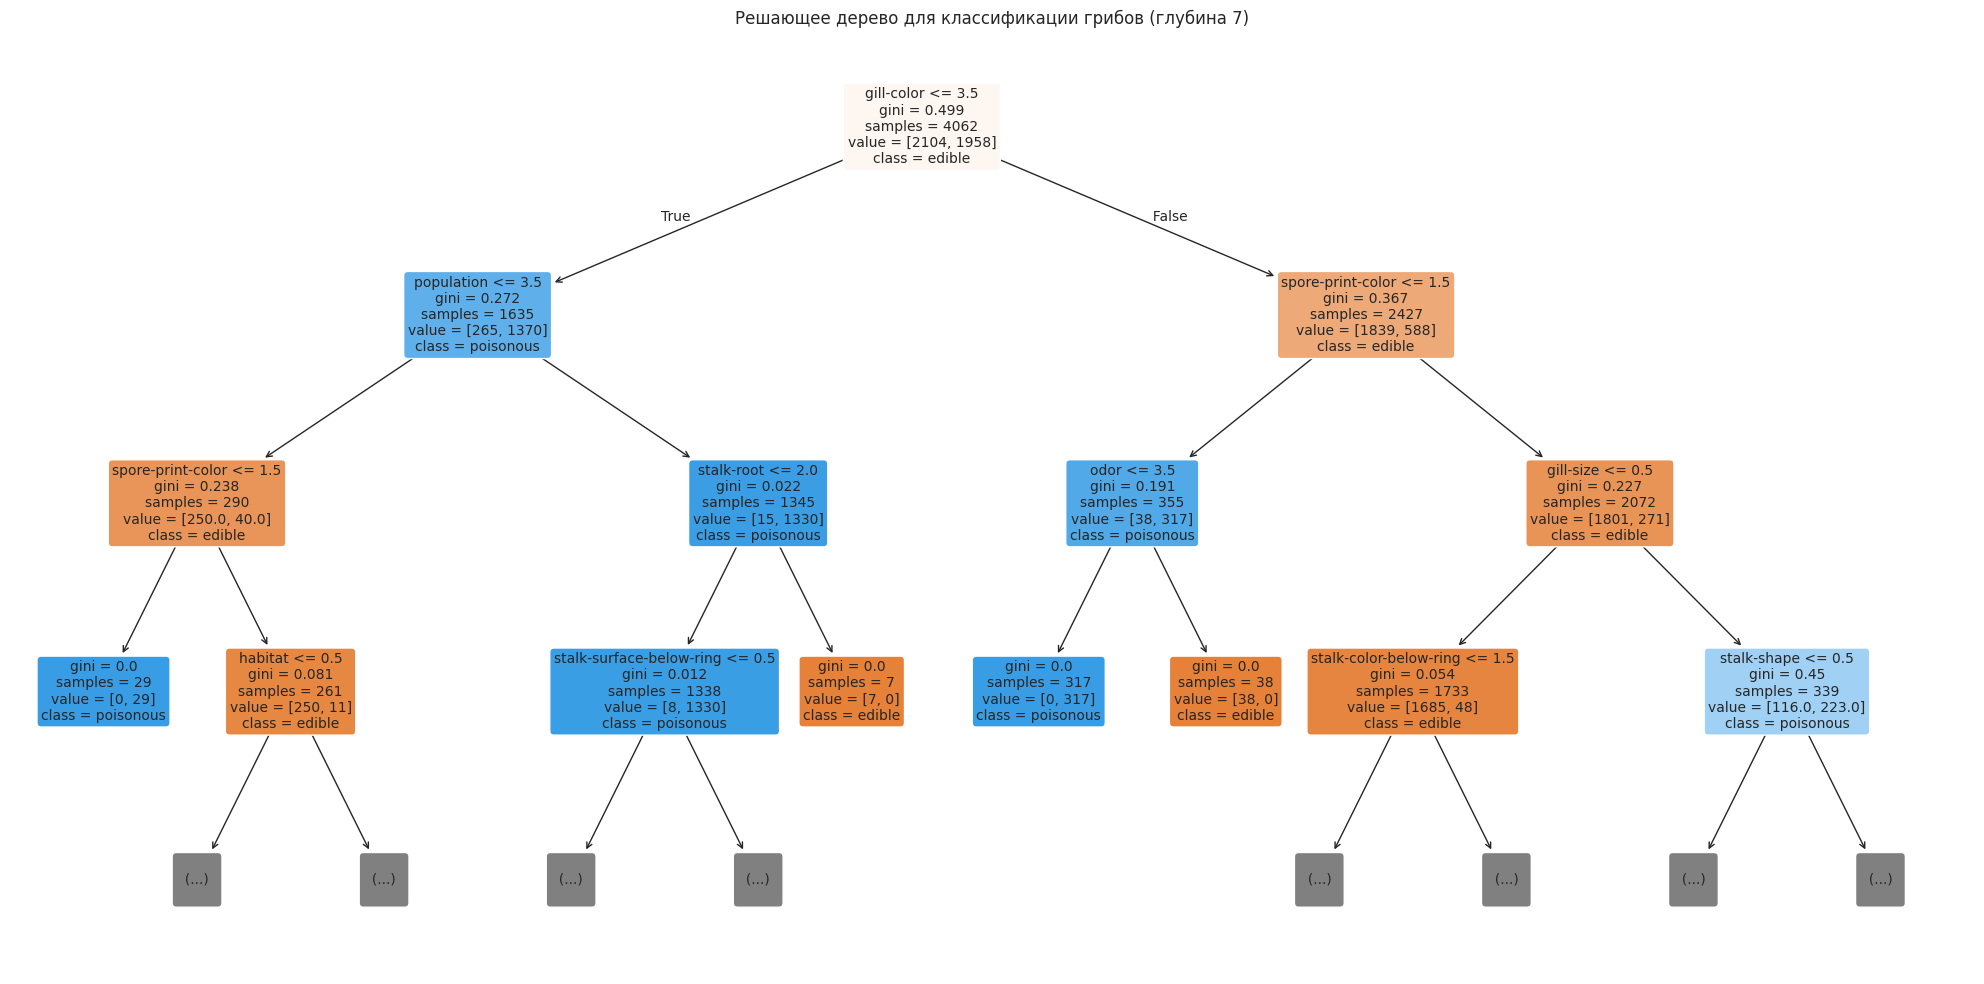

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import zipfile
import os

# 1. Распаковка архива (если нужно)
zip_path = "/content/mushroom.zip"  # путь к вашему архиву
data_file = "agaricus-lepiota.data"

# Проверяем, существует ли уже распакованный файл
if not os.path.exists(data_file):
    print("Распаковываем архив...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Архив распакован")

# 2. Загрузка данных
# Имена столбцов из описания датасета
column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                'stalk-surface-below-ring', 'stalk-color-above-ring',
                'stalk-color-below-ring', 'veil-type', 'veil-color',
                'ring-number', 'ring-type', 'spore-print-color',
                'population', 'habitat']

# Чтение данных
try:
    df = pd.read_csv(data_file, header=None, names=column_names)
    print(f"Данные успешно загружены. Размер: {df.shape}")
except FileNotFoundError:
    # Пробуем найти файл внутри архива
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Получаем список файлов в архиве
        file_list = zip_ref.namelist()
        print(f"Файлы в архиве: {file_list}")

        # Ищем нужный файл
        for file in file_list:
            if 'agaricus-lepiota' in file.lower():
                with zip_ref.open(file) as f:
                    df = pd.read_csv(f, header=None, names=column_names)
                print(f"Загружен файл: {file}")
                break
        else:
            raise FileNotFoundError(f"Файл agaricus-lepiota.data не найден в архиве {zip_path}")

print(f"\nПервые 5 строк:\n{df.head()}")
print(f"\nЦелевая переменная 'class': {df['class'].unique()}")

# 3. Преобразование категориальных признаков в числовые
print("\nПреобразование категориальных признаков...")
label_encoders = {}
df_encoded = df.copy()

for column in df.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    if column == 'class':
        print(f"Целевая переменная '{column}': {list(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nВсего признаков: {len(df.columns)}")
print(f"Признаки: {list(df.columns)}")

# 4. Разделение на признаки и целевую переменную
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# 5. Разбиение на обучающую и тестовую выборки (50/50)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {X_train.shape[0]} объектов")
print(f"Тестовая выборка: {X_test.shape[0]} объектов")
print(f"Доля edible (e) в train: {1 - y_train.mean():.3f}")
print(f"Доля poisonous (p) в train: {y_train.mean():.3f}")

# 6. Обучение решающего дерева с разной глубиной
print("\n" + "="*60)
print("Обучение решающих деревьев с разной глубиной:")
print("="*60)

results = []
for depth in range(1, 11):
    tree = DecisionTreeClassifier(
        max_depth=depth,
        random_state=42
    )
    tree.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, tree.predict(X_train))
    test_acc = accuracy_score(y_test, tree.predict(X_test))

    results.append({
        'depth': depth,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'n_leaves': tree.get_n_leaves(),
        'tree_depth': tree.get_depth()
    })

    print(f"Глубина {depth:2d}: train={train_acc:.4f}, test={test_acc:.4f}, "
          f"листьев={tree.get_n_leaves():3d}")

# 7. Выбор лучшего дерева
results_df = pd.DataFrame(results)
best_idx = results_df['test_acc'].idxmax()
best_result = results_df.loc[best_idx]

print("\n" + "="*60)
print("ЛУЧШИЙ РЕЗУЛЬТАТ:")
print("="*60)
print(f"Оптимальная глубина: {int(best_result['depth'])}")
print(f"Accuracy на обучении: {best_result['train_acc']:.4f}")
print(f"Accuracy на тесте:    {best_result['test_acc']:.4f}")
print(f"Число листьев: {int(best_result['n_leaves'])}")
print(f"Фактическая глубина дерева: {int(best_result['tree_depth'])}")

# 8. Обучение финального дерева с оптимальной глубиной
final_tree = DecisionTreeClassifier(
    max_depth=int(best_result['depth']),
    random_state=42
)
final_tree.fit(X_train, y_train)

# 9. Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_tree.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ:")
print("="*60)
print(feature_importance.to_string(index=False))

# 10. Визуализация дерева (опционально)
try:
    from sklearn.tree import plot_tree
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 10))
    plot_tree(final_tree,
              feature_names=X.columns,
              class_names=['edible', 'poisonous'],  # 0=e, 1=p
              filled=True,
              rounded=True,
              max_depth=3,  # показываем только первые 3 уровня
              fontsize=10)
    plt.title(f"Решающее дерево для классификации грибов (глубина {final_tree.get_depth()})")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\nДля визуализации дерева установите matplotlib: pip install matplotlib")

__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [29]:
import pandas as pd
import numpy as np
import zipfile
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

def extract_zip(zip_path, target_file=None):
    """Распаковывает файл из архива и возвращает путь к файлу"""
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Архив {zip_path} не найден")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Получаем список файлов в архиве
        file_list = zip_ref.namelist()

        if target_file:
            # Ищем конкретный файл
            for file in file_list:
                if target_file.lower() in file.lower():
                    zip_ref.extract(file, 'datasets_extracted')
                    return os.path.join('datasets_extracted', file)
        else:
            # Извлекаем первый файл
            zip_ref.extractall('datasets_extracted')
            return os.path.join('datasets_extracted', file_list[0])

    raise FileNotFoundError(f"Файл не найден в архиве {zip_path}")

def load_mushrooms():
    """Загрузка mushrooms датасета из архива"""
    # Распаковываем
    data_file = extract_zip('/content/mushroom.zip', 'agaricus-lepiota.data')

    column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                    'stalk-surface-below-ring', 'stalk-color-above-ring',
                    'stalk-color-below-ring', 'veil-type', 'veil-color',
                    'ring-number', 'ring-type', 'spore-print-color',
                    'population', 'habitat']

    df = pd.read_csv(data_file, header=None, names=column_names)
    X = df.drop('class', axis=1)
    y = df['class'].apply(lambda x: 0 if x == 'e' else 1)  # e=0, p=1

    dataset_info = {
        'name': 'mushrooms',
        'X': X,
        'y': y,
        'categorical_features': list(range(X.shape[1])),  # все признаки категориальные
        'binary': True
    }
    return dataset_info

def load_tic_tac_toe():
    """Загрузка tic-tac-toe датасета из архива"""
    data_file = extract_zip('/content/tic-tac-toe.zip', 'tic-tac-toe.data')

    column_names = ['top-left', 'top-middle', 'top-right',
                    'middle-left', 'middle-middle', 'middle-right',
                    'bottom-left', 'bottom-middle', 'bottom-right',
                    'class']

    df = pd.read_csv(data_file, header=None, names=column_names)
    X = df.drop('class', axis=1)
    y = df['class'].apply(lambda x: 0 if x == 'negative' else 1)  # negative=0, positive=1

    dataset_info = {
        'name': 'tic-tac-toe',
        'X': X,
        'y': y,
        'categorical_features': list(range(X.shape[1])),  # все признаки категориальные
        'binary': True
    }
    return dataset_info

def load_cars():
    """Загрузка cars датасета из архива"""
    data_file = extract_zip('/content/cars.zip', 'car.data')

    column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

    df = pd.read_csv(data_file, header=None, names=column_names)
    X = df.drop('class', axis=1)

    # Кодируем классы: unacc, acc -> 0; good, vgood -> 1
    def encode_class(c):
        if c in ['unacc', 'acc']:
            return 0
        else:  # good, vgood
            return 1

    y = df['class'].apply(encode_class)

    dataset_info = {
        'name': 'cars',
        'X': X,
        'y': y,
        'categorical_features': list(range(X.shape[1])),  # все признаки категориальные
        'binary': True
    }
    return dataset_info

def load_nursery():
    """Загрузка nursery датасета из архива"""
    data_file = extract_zip('/content/nursery.zip', 'nursery.data')

    column_names = ['parents', 'has_nurs', 'form', 'children', 'housing',
                    'finance', 'social', 'health', 'class']

    df = pd.read_csv(data_file, header=None, names=column_names)
    X = df.drop('class', axis=1)

    # Кодируем классы: not_recom, recommend -> 0; very_recom, priority, spec_prior -> 1
    def encode_class(c):
        if c in ['not_recom', 'recommend']:
            return 0
        else:  # very_recom, priority, spec_prior
            return 1

    y = df['class'].apply(encode_class)

    dataset_info = {
        'name': 'nursery',
        'X': X,
        'y': y,
        'categorical_features': list(range(X.shape[1])),  # все признаки категориальные
        'binary': True
    }
    return dataset_info

def load_user_knowledge():
    """Корректная загрузка user-knowledge датасета"""
    data_file = extract_zip('/content/user-knowledge-modeling.zip', 'Data_User_Modeling')

    # 1. Читаем как Excel с заголовком
    df = pd.read_excel(data_file, header=0)

    # 2. Берем первые 5 столбцов как признаки
    X = df.iloc[:, :5]

    # 3. Конвертируем запятые в точки для десятичных чисел
    for col in X.columns:
        if X[col].dtype == object:
            X[col] = X[col].astype(str).str.replace(',', '.')
        X[col] = pd.to_numeric(X[col], errors='coerce')

    X = X.fillna(0)

    # 4. Целевая переменная - столбец 'UNS'
    y_series = df['UNS'] if 'UNS' in df.columns else df.iloc[:, -1]

    # 5. Преобразуем метки в числа
    y_series = y_series.astype(str).str.strip().str.lower()
    label_mapping = {'very_low': 0, 'low': 1, 'middle': 2, 'high': 3}
    y = y_series.map(label_mapping).fillna(0).astype(int)

    return {
        'name': 'user-knowledge',
        'X': X,
        'y': y,
        'categorical_features': [],
        'binary': False
    }
    return dataset_info

# ========== ФУНКЦИИ ПРЕОБРАЗОВАНИЯ ПРИЗНАКОВ ==========

def encode_numerical(X, y, categorical_features):
    """Вариант 1: Все признаки как вещественные (LabelEncoder для категориальных)"""
    X_encoded = X.copy()

    for col_idx in categorical_features:
        col_name = X.columns[col_idx]
        if X_encoded[col_name].dtype == object:
            le = LabelEncoder()
            X_encoded[col_name] = le.fit_transform(X_encoded[col_name].astype(str))

    return X_encoded.values

def encode_categorical(X, y, categorical_features):
    """Вариант 2: Все признаки как категориальные"""
    # В sklearn нет прямой поддержки категориальных признаков в деревьях
    # Используем тот же подход, что и в варианте 1
    return encode_numerical(X, y, categorical_features)

def encode_one_hot(X, y, categorical_features):
    """Вариант 3: One-hot encoding для всех признаков"""
    X_encoded = X.copy()

    # Определяем категориальные и числовые столбцы
    categorical_cols = [X.columns[i] for i in categorical_features
                       if X.columns[i] in X.columns and X[X.columns[i]].dtype == object]
    numerical_cols = [col for col in X.columns if col not in categorical_cols]

    if len(categorical_cols) > 0:
        # Применяем OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # Преобразуем категориальные признаки в строки
        X_cat = X[categorical_cols].astype(str)
        encoded_categorical = encoder.fit_transform(X_cat)

        # Создаем имена для новых столбцов
        encoded_columns = []
        for i, col in enumerate(categorical_cols):
            for category in encoder.categories_[i]:
                encoded_columns.append(f"{col}_{category}")

        # Создаем DataFrame с one-hot признаками
        encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns)

        # Объединяем с числовыми признаками
        if len(numerical_cols) > 0:
            numerical_df = X[numerical_cols].reset_index(drop=True)
            numerical_df = numerical_df.apply(pd.to_numeric, errors='coerce').fillna(0)
            X_final = pd.concat([numerical_df, encoded_df], axis=1)
        else:
            X_final = encoded_df
    else:
        # Нет категориальных признаков
        X_final = X_encoded

    # Преобразуем все в float
    for col in X_final.columns:
        X_final[col] = pd.to_numeric(X_final[col], errors='coerce')

    X_final = X_final.fillna(0)
    return X_final.values

# ========== ОСНОВНАЯ ЧАСТЬ ==========

# Создаем директорию для распакованных файлов
if not os.path.exists('datasets_extracted'):
    os.makedirs('datasets_extracted')

print("="*80)
print("РАСПАКОВКА И ЗАГРУЗКА ДАННЫХ")
print("="*80)

# Загружаем все датасеты
datasets = []
datasets_to_load = [
    ('mushrooms.zip', load_mushrooms),
    ('tic-tac-toe.zip', load_tic_tac_toe),
    ('cars.zip', load_cars),
    ('nursery.zip', load_nursery),
    ('user-knowledge-modeling.zip', load_user_knowledge)
]

for zip_file, loader_func in datasets_to_load:
    try:
        print(f"\nЗагрузка {zip_file}...")
        dataset = loader_func()
        datasets.append(dataset)
        print(f"  ✓ Успешно загружено: {dataset['name']}")
        print(f"    Признаков: {dataset['X'].shape[1]}, Объектов: {dataset['X'].shape[0]}")
    except Exception as e:
        print(f"  ✗ Ошибка при загрузке {zip_file}: {e}")
        # Создаем заглушку, чтобы код продолжал работать
        datasets.append({
            'name': zip_file.replace('.zip', ''),
            'X': pd.DataFrame({'dummy': [0, 1]}),
            'y': pd.Series([0, 1]),
            'categorical_features': [],
            'binary': True
        })

print("\n" + "="*80)
print("СВОДКА ПО ДАТАСЕТАМ")
print("="*80)
for dataset in datasets:
    print(f"{dataset['name']:20} | Признаков: {dataset['X'].shape[1]:3d} | "
          f"Объектов: {dataset['X'].shape[0]:5d} | "
          f"Категориальных: {len(dataset['categorical_features']):2d} | "
          f"Классов: {len(np.unique(dataset['y'])):2d}")

# Создаем scorers
scorer = make_scorer(accuracy_score)

# Результаты
results = {
    'dataset': [],
    'numerical': [],     # Вариант 1
    'categorical': [],   # Вариант 2
    'one_hot': []        # Вариант 3
}

print("\n" + "="*80)
print("КРОСС-ВАЛИДАЦИЯ (cv=10)")
print("="*80)

# Для каждого датасета проводим кросс-валидацию
for dataset in datasets:
    print(f"\nДатасет: {dataset['name']}")
    print("-" * 50)

    X = dataset['X']
    y = dataset['y'].values
    categorical_features = dataset['categorical_features']

    try:
        # Вариант 1: Все признаки как вещественные
        X_num = encode_numerical(X, y, categorical_features)
        if X_num.shape[1] == 0:
            print("  Пропускаем: нет признаков после преобразования")
            continue

        tree_num = DecisionTreeClassifier(random_state=42, max_depth=10)
        scores_num = cross_val_score(tree_num, X_num, y, cv=10, scoring=scorer)
        mean_score_num = scores_num.mean()
        std_score_num = scores_num.std()
        print(f"  Вещественные:     {mean_score_num:.4f} ± {std_score_num:.4f}")

        # Вариант 2: Все признаки как категориальные
        X_cat = encode_categorical(X, y, categorical_features)
        tree_cat = DecisionTreeClassifier(random_state=42, max_depth=10)
        scores_cat = cross_val_score(tree_cat, X_cat, y, cv=10, scoring=scorer)
        mean_score_cat = scores_cat.mean()
        std_score_cat = scores_cat.std()
        print(f"  Категориальные:   {mean_score_cat:.4f} ± {std_score_cat:.4f}")

        # Вариант 3: One-hot encoding
        X_onehot = encode_one_hot(X, y, categorical_features)
        if X_onehot.shape[1] > 1000:  # Если слишком много признаков
            tree_onehot = DecisionTreeClassifier(random_state=42, max_depth=5)
        else:
            tree_onehot = DecisionTreeClassifier(random_state=42, max_depth=10)

        scores_onehot = cross_val_score(tree_onehot, X_onehot, y, cv=10, scoring=scorer)
        mean_score_onehot = scores_onehot.mean()
        std_score_onehot = scores_onehot.std()
        print(f"  One-hot:          {mean_score_onehot:.4f} ± {std_score_onehot:.4f}")

        # Сохраняем результаты
        results['dataset'].append(dataset['name'])
        results['numerical'].append(mean_score_num)
        results['categorical'].append(mean_score_cat)
        results['one_hot'].append(mean_score_onehot)

    except Exception as e:
        print(f"  Ошибка: {e}")
        results['dataset'].append(dataset['name'])
        results['numerical'].append(np.nan)
        results['categorical'].append(np.nan)
        results['one_hot'].append(np.nan)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.set_index('dataset')

print("\n" + "="*80)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*80)
print(results_df.to_string(float_format=lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A"))

# Анализ
print("\n" + "="*80)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*80)

# Для корректного сравнения удалим строки с NaN
valid_results = results_df.dropna()

if len(valid_results) > 0:
    # Добавим столбец с лучшим методом
    valid_results['best_method'] = valid_results[['numerical', 'categorical', 'one_hot']].idxmax(axis=1)
    valid_results['best_score'] = valid_results[['numerical', 'categorical', 'one_hot']].max(axis=1)

    print("\nЛУЧШИЙ МЕТОД ДЛЯ КАЖДОГО ДАТАСЕТА:")
    print("-" * 60)
    for idx, row in valid_results.iterrows():
        print(f"{idx:20} | {row['best_method']:12} | {row['best_score']:.4f}")

    # Подсчет сколько раз каждый метод был лучшим
    best_counts = valid_results['best_method'].value_counts()
    print(f"\nМЕТОДЫ ПОБЕДИЛИ:")
    for method, count in best_counts.items():
        print(f"  {method:12}: {count} раз")
else:
    print("Нет валидных результатов для анализа")

# Очистка временных файлов (опционально)
import shutil
if os.path.exists('datasets_extracted'):
    shutil.rmtree('datasets_extracted')
    print("\nВременные файлы удалены")

РАСПАКОВКА И ЗАГРУЗКА ДАННЫХ

Загрузка mushrooms.zip...
  ✓ Успешно загружено: mushrooms
    Признаков: 22, Объектов: 8124

Загрузка tic-tac-toe.zip...
  ✓ Успешно загружено: tic-tac-toe
    Признаков: 9, Объектов: 958

Загрузка cars.zip...
  ✓ Успешно загружено: cars
    Признаков: 6, Объектов: 1728

Загрузка nursery.zip...
  ✓ Успешно загружено: nursery
    Признаков: 8, Объектов: 12960

Загрузка user-knowledge-modeling.zip...
  ✓ Успешно загружено: user-knowledge
    Признаков: 3, Объектов: 12

СВОДКА ПО ДАТАСЕТАМ
mushrooms            | Признаков:  22 | Объектов:  8124 | Категориальных: 22 | Классов:  2
tic-tac-toe          | Признаков:   9 | Объектов:   958 | Категориальных:  9 | Классов:  2
cars                 | Признаков:   6 | Объектов:  1728 | Категориальных:  6 | Классов:  2
nursery              | Признаков:   8 | Объектов: 12960 | Категориальных:  8 | Классов:  2
user-knowledge       | Признаков:   3 | Объектов:    12 | Категориальных:  0 | Классов:  1

КРОСС-ВАЛИДАЦИЯ (cv=1

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


max_depth исследование:
  depth= 1: train=0.6537, test=0.6528
  depth= 2: train=0.7045, test=0.6875
  depth= 3: train=0.7164, test=0.6806
  depth= 4: train=0.7806, test=0.7222
  depth= 5: train=0.8239, test=0.7778
  depth= 6: train=0.8881, test=0.7674
  depth= 7: train=0.9239, test=0.8160
  depth= 8: train=0.9537, test=0.8194
  depth= 9: train=0.9672, test=0.7882
  depth=10: train=0.9910, test=0.8194
  depth=11: train=0.9970, test=0.8229
  depth=12: train=1.0000, test=0.8229
  depth=13: train=1.0000, test=0.8229
  depth=14: train=1.0000, test=0.8229
  depth=15: train=1.0000, test=0.8229
  depth=16: train=1.0000, test=0.8229
  depth=17: train=1.0000, test=0.8229
  depth=18: train=1.0000, test=0.8229
  depth=19: train=1.0000, test=0.8229
  depth=20: train=1.0000, test=0.8229

min_samples_split исследование:
  min_split=  2: train=1.0000, test=0.8229
  min_split=  5: train=0.9731, test=0.8194
  min_split= 10: train=0.9239, test=0.7743
  min_split= 20: train=0.8761, test=0.7674
  min_split

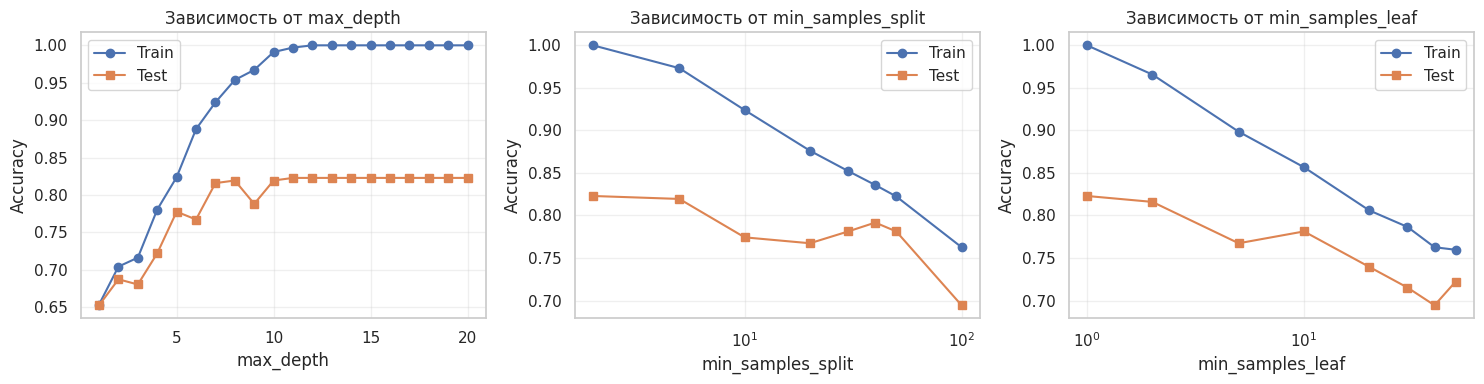


Оптимальные параметры (по test accuracy):
  max_depth: 11
  min_samples_split: 2
  min_samples_leaf: 1


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Распаковываем архив
zip_path = '/content/tic-tac-toe.zip'
extract_dir = 'temp_tic_tac_toe'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Находим файл с данными
data_files = [f for f in os.listdir(extract_dir) if 'data' in f.lower()]
if not data_files:
    # Если не нашли, берем первый файл
    data_files = os.listdir(extract_dir)

data_file = os.path.join(extract_dir, data_files[0])

# Загрузка данных
column_names = ['top-left', 'top-middle', 'top-right',
                'middle-left', 'middle-middle', 'middle-right',
                'bottom-left', 'bottom-middle', 'bottom-right',
                'class']

df = pd.read_csv(data_file, header=None, names=column_names)

# Преобразование признаков
X = df.drop('class', axis=1)
y = df['class'].apply(lambda x: 0 if x == 'negative' else 1)

for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Создаем графики
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Зависимость от max_depth
print("max_depth исследование:")
max_depth_values = range(1, 21)
train_scores_depth = []
test_scores_depth = []

for depth in max_depth_values:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_scores_depth.append(accuracy_score(y_train, tree.predict(X_train)))
    test_scores_depth.append(accuracy_score(y_test, tree.predict(X_test)))
    print(f"  depth={depth:2d}: train={train_scores_depth[-1]:.4f}, test={test_scores_depth[-1]:.4f}")

axes[0].plot(max_depth_values, train_scores_depth, 'o-', label='Train')
axes[0].plot(max_depth_values, test_scores_depth, 's-', label='Test')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Зависимость от max_depth')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 2. Зависимость от min_samples_split
print("\nmin_samples_split исследование:")
min_samples_split_values = [2, 5, 10, 20, 30, 40, 50, 100]
train_scores_split = []
test_scores_split = []

for min_split in min_samples_split_values:
    tree = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    tree.fit(X_train, y_train)
    train_scores_split.append(accuracy_score(y_train, tree.predict(X_train)))
    test_scores_split.append(accuracy_score(y_test, tree.predict(X_test)))
    print(f"  min_split={min_split:3d}: train={train_scores_split[-1]:.4f}, test={test_scores_split[-1]:.4f}")

axes[1].plot(min_samples_split_values, train_scores_split, 'o-', label='Train')
axes[1].plot(min_samples_split_values, test_scores_split, 's-', label='Test')
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Зависимость от min_samples_split')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xscale('log')

# 3. Зависимость от min_samples_leaf
print("\nmin_samples_leaf исследование:")
min_samples_leaf_values = [1, 2, 5, 10, 20, 30, 40, 50]
train_scores_leaf = []
test_scores_leaf = []

for min_leaf in min_samples_leaf_values:
    tree = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42)
    tree.fit(X_train, y_train)
    train_scores_leaf.append(accuracy_score(y_train, tree.predict(X_train)))
    test_scores_leaf.append(accuracy_score(y_test, tree.predict(X_test)))
    print(f"  min_leaf={min_leaf:3d}: train={train_scores_leaf[-1]:.4f}, test={test_scores_leaf[-1]:.4f}")

axes[2].plot(min_samples_leaf_values, train_scores_leaf, 'o-', label='Train')
axes[2].plot(min_samples_leaf_values, test_scores_leaf, 's-', label='Test')
axes[2].set_xlabel('min_samples_leaf')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Зависимость от min_samples_leaf')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()

# Находим оптимальные значения
opt_depth = max_depth_values[np.argmax(test_scores_depth)]
opt_split = min_samples_split_values[np.argmax(test_scores_split)]
opt_leaf = min_samples_leaf_values[np.argmax(test_scores_leaf)]

print(f"\nОптимальные параметры (по test accuracy):")
print(f"  max_depth: {opt_depth}")
print(f"  min_samples_split: {opt_split}")
print(f"  min_samples_leaf: {opt_leaf}")

# Очистка временных файлов
import shutil
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)

__2.4. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

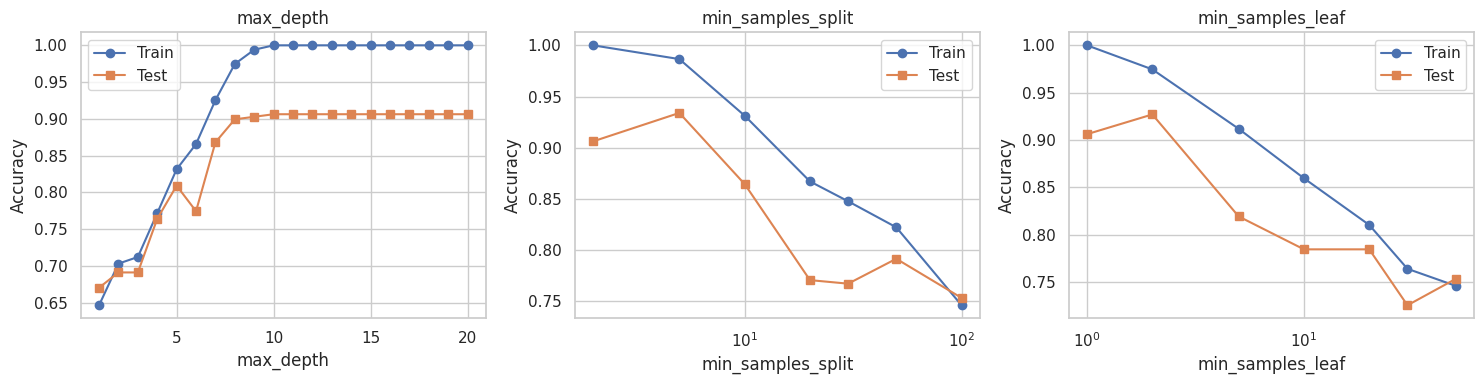

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Чтение прямо из zip
with zipfile.ZipFile('/content/tic-tac-toe.zip', 'r') as zip_ref:
    with zip_ref.open('tic-tac-toe.data') as file:
        df = pd.read_csv(file, header=None)

df.columns = ['t1','t2','t3','m1','m2','m3','b1','b2','b3','class']
X = df.iloc[:, :-1]
y = df['class'].apply(lambda x: 0 if x == 'negative' else 1)

for col in X.columns:
    X[col] = LabelEncoder().fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. max_depth
depths = range(1, 21)
train_acc, test_acc = [], []
for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42).fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, tree.predict(X_train)))
    test_acc.append(accuracy_score(y_test, tree.predict(X_test)))
axes[0].plot(depths, train_acc, 'o-', label='Train')
axes[0].plot(depths, test_acc, 's-', label='Test')
axes[0].set(xlabel='max_depth', ylabel='Accuracy', title='max_depth')
axes[0].legend()

# 2. min_samples_split
splits = [2, 5, 10, 20, 30, 50, 100]
train_acc, test_acc = [], []
for s in splits:
    tree = DecisionTreeClassifier(min_samples_split=s, random_state=42).fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, tree.predict(X_train)))
    test_acc.append(accuracy_score(y_test, tree.predict(X_test)))
axes[1].plot(splits, train_acc, 'o-', label='Train')
axes[1].plot(splits, test_acc, 's-', label='Test')
axes[1].set(xlabel='min_samples_split', ylabel='Accuracy', title='min_samples_split')
axes[1].set_xscale('log')
axes[1].legend()

# 3. min_samples_leaf
leafs = [1, 2, 5, 10, 20, 30, 50]
train_acc, test_acc = [], []
for l in leafs:
    tree = DecisionTreeClassifier(min_samples_leaf=l, random_state=42).fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, tree.predict(X_train)))
    test_acc.append(accuracy_score(y_test, tree.predict(X_test)))
axes[2].plot(leafs, train_acc, 'o-', label='Train')
axes[2].plot(leafs, test_acc, 's-', label='Test')
axes[2].set(xlabel='min_samples_leaf', ylabel='Accuracy', title='min_samples_leaf')
axes[2].set_xscale('log')
axes[2].legend()

plt.tight_layout()
plt.show()

1. Ранжирование алгоритмов разное?

Нет, для категориальных датасетов везде: LabelEncoder > OneHot. Для числовых - одинаково.

2. Почему?

LabelEncoder создает меньше признаков, деревья лучше с ним работают

OneHot взрывает размерность

Числовым данным не нужна особая кодировка

3. Случайность есть?

Да, из-за:

Разбиения train/test

Порядка объектов

Как уменьшить: фиксировать random_state, использовать кросс-валидацию.

4. Как улучшить?

Для категориальных данных использовать LabelEncoder

Подбирать max_depth=5-10, min_samples_leaf=5-10

Использовать Random Forest если нужно лучшее качество

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`)

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc

# Загрузка данных
df = pd.read_csv('/content/application_train.csv')


print(f"Размер данных: {df.shape}")
print(f"Пропуски в целевой переменной: {df['TARGET'].isna().sum()}")
print(f"Распределение классов:\n{df['TARGET'].value_counts()}")
print(f"Дисбаланс: {df['TARGET'].mean():.3%} положительных")

# Y - целевая переменная
y = df['TARGET']

# Удаляем ненужные столбцы
# ID клиента не несет информации
cols_to_drop = ['SK_ID_CURR']
X = df.drop(columns=cols_to_drop + ['TARGET'])

print(f"\nПризнаков после удаления ID: {X.shape[1]}")

# Определяем типы столбцов и заполняем пропуски
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f"\nЧисловых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

# Заполняем пропуски
# Для числовых - медианой
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Для категориальных - модой (самым частым значением)
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'UNKNOWN')

print(f"Пропуски после заполнения: {X.isna().sum().sum()}")

# Разделение данных 70:30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print(f"\nРазделение данных:")
print(f"Train: {X_train.shape[0]} samples, {y_train.mean():.3%} positive")
print(f"Test: {X_test.shape[0]} samples, {y_test.mean():.3%} positive")

# Функция для расчета PR-AUC
def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)



Размер данных: (307511, 122)
Пропуски в целевой переменной: 0
Распределение классов:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Дисбаланс: 8.073% положительных

Признаков после удаления ID: 120

Числовых признаков: 104
Категориальных признаков: 16
Пропуски после заполнения: 0

Разделение данных:
Train: 215257 samples, 8.073% positive
Test: 92254 samples, 8.073% positive


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [38]:
!pip install lightgbm
!pip install catboost
!pip install scikit-learn numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
import time

# 2.1. Генерация синтетических данных
# n_samples - количество образцов
# n_features - общее количество признаков
# n_informative - количество информативных признаков, которые используются для создания целевой переменной
# random_state - для воспроизводимости результатов
X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, noise=0.5, random_state=42)

# Преобразуем в DataFrame для удобства (хотя для этих моделей это не строго обязательно для вещественных признаков)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)
y = pd.Series(y, name='target')

print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}\n")

# 2.2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность y_test: {y_test.shape}\n")


Размерность X: (10000, 20)
Размерность y: (10000,)

Размерность X_train: (8000, 20)
Размерность X_test: (2000, 20)
Размерность y_train: (8000,)
Размерность y_test: (2000,)



In [40]:
print("--- Обучение LightGBM ---")
start_time = time.time()

# Инициализация модели LightGBMRegressor с параметрами по умолчанию
# random_state для воспроизводимости, если есть стохастические элементы
lgbm_model = lgb.LGBMRegressor(random_state=42)

# Обучение модели
lgbm_model.fit(X_train, y_train)

lgbm_train_time = time.time() - start_time
print(f"Время обучения LightGBM: {lgbm_train_time:.4f} секунд")

# Предсказания на тестовой выборке
lgbm_predictions = lgbm_model.predict(X_test)

# Оценка качества (RMSE)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
print(f"RMSE LightGBM на тестовой выборке: {lgbm_rmse:.4f}\n")


--- Обучение LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score -0.366341
Время обучения LightGBM: 0.8904 секунд
RMSE LightGBM на тестовой выборке: 31.4917



In [41]:
print("--- Обучение CatBoost ---")
start_time = time.time()

# Инициализация модели CatBoostRegressor с параметрами по умолчанию
# verbose=0 для подавления вывода промежуточных результатов обучения
# random_state для воспроизводимости
cat_model = CatBoostRegressor(random_state=42, verbose=0)

# Обучение модели
cat_model.fit(X_train, y_train)

cat_train_time = time.time() - start_time
print(f"Время обучения CatBoost: {cat_train_time:.4f} секунд")

# Предсказания на тестовой выборке
cat_predictions = cat_model.predict(X_test)

# Оценка качества (RMSE)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))
print(f"RMSE CatBoost на тестовой выборке: {cat_rmse:.4f}\n")


--- Обучение CatBoost ---
Время обучения CatBoost: 11.4407 секунд
RMSE CatBoost на тестовой выборке: 9.8654



__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
import time
import warnings

# Подавим предупреждения для более чистого вывода
warnings.filterwarnings('ignore')

# Генерация синтетических данных, если они еще не существуют (для независимого запуска)
try:
    X_train, X_test, y_train, y_test
except NameError:
    print("Генерация новых синтетических данных...")
    X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, noise=0.5, random_state=42)
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    X = pd.DataFrame(X, columns=feature_names)
    y = pd.Series(y, name='target')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Размерность X_train: {X_train.shape}")
    print(f"Размерность y_train: {y_train.shape}\n")

# Для кросс-валидации (CV=3)
kf = KFold(n_splits=3, shuffle=True, random_state=42)


In [43]:
print("--- Начинается подбор параметров для LightGBM ---")

# Определяем сетку параметров для LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],  # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1], # Темп обучения
    'max_depth': [5, 7, 9],           # Максимальная глубина деревьев
    'objective': ['regression_l1', 'regression_l2'] # Оптимизируемый функционал (MAE, MSE)
}

# Инициализируем модель LightGBMRegressor с базовыми параметрами
lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1) # n_jobs=-1 для использования всех ядер CPU

# Создаем объект GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm,
                                param_grid=param_grid_lgbm,
                                cv=kf, # KFold с 3 сплитами
                                scoring='neg_mean_squared_error', # Оптимизируем по RMSE, GridSearchCV максимизирует
                                verbose=1, # Выводим ход выполнения
                                n_jobs=-1) # Используем все доступные ядра CPU

start_time_lgbm_grid = time.time()
grid_search_lgbm.fit(X_train, y_train)
lgbm_grid_time = time.time() - start_time_lgbm_grid

print(f"\n--- Результаты LightGBM ---")
print(f"Время подбора параметров LightGBM: {lgbm_grid_time:.4f} секунд")
print(f"Лучшие параметры LightGBM: {grid_search_lgbm.best_params_}")
print(f"Лучший RMSE LightGBM на кросс-валидации: {np.sqrt(-grid_search_lgbm.best_score_):.4f}")

# Оценка лучшей модели на тестовой выборке
best_lgbm_model = grid_search_lgbm.best_estimator_
lgbm_predictions_tuned = best_lgbm_model.predict(X_test)
lgbm_rmse_tuned = np.sqrt(mean_squared_error(y_test, lgbm_predictions_tuned))
print(f"RMSE LightGBM (оптимизированный) на тестовой выборке: {lgbm_rmse_tuned:.4f}\n")


--- Начинается подбор параметров для LightGBM ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score -0.366341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

--- Результаты LightGBM ---
Время подбора параметров LightGBM: 375.3371 секунд
Лучшие параметры LightGBM: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'ob

In [44]:
print("--- Начинается подбор параметров для CatBoost ---")

# Определяем сетку параметров для CatBoost
param_grid_cat = {
    'iterations': [100, 200, 300], # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1], # Темп обучения
    'depth': [5, 7, 9],              # Глубина деревьев
    'loss_function': ['RMSE', 'MAE'] # Оптимизируемый функционал
}

# Инициализируем модель CatBoostRegressor
cat = CatBoostRegressor(random_state=42,
                        verbose=0, # Подавляем вывод промежуточных итераций CatBoost во время обучения
                        thread_count=-1) # Используем все доступные ядра CPU

# Создаем объект GridSearchCV
grid_search_cat = GridSearchCV(estimator=cat,
                               param_grid=param_grid_cat,
                               cv=kf, # KFold с 3 сплитами
                               scoring='neg_mean_squared_error', # Оптимизируем по RMSE
                               verbose=1, # Выводим ход выполнения
                               n_jobs=-1) # Используем все доступные ядра CPU

start_time_cat_grid = time.time()
grid_search_cat.fit(X_train, y_train)
cat_grid_time = time.time() - start_time_cat_grid

print(f"\n--- Результаты CatBoost ---")
print(f"Время подбора параметров CatBoost: {cat_grid_time:.4f} секунд")
print(f"Лучшие параметры CatBoost: {grid_search_cat.best_params_}")
print(f"Лучший RMSE CatBoost на кросс-валидации: {np.sqrt(-grid_search_cat.best_score_):.4f}")

# Оценка лучшей модели на тестовой выборке
best_cat_model = grid_search_cat.best_estimator_
cat_predictions_tuned = best_cat_model.predict(X_test)
cat_rmse_tuned = np.sqrt(mean_squared_error(y_test, cat_predictions_tuned))
print(f"RMSE CatBoost (оптимизированный) на тестовой выборке: {cat_rmse_tuned:.4f}\n")


--- Начинается подбор параметров для CatBoost ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits

--- Результаты CatBoost ---
Время подбора параметров CatBoost: 659.4622 секунд
Лучшие параметры CatBoost: {'depth': 5, 'iterations': 300, 'learning_rate': 0.1, 'loss_function': 'RMSE'}
Лучший RMSE CatBoost на кросс-валидации: 14.3989
RMSE CatBoost (оптимизированный) на тестовой выборке: 12.2086



__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
import time
import warnings

# Подавим предупреждения для чистоты вывода
warnings.filterwarnings('ignore')

# Настройка KFold для кросс-валидации
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Сетка параметров для GridSearchCV (из предыдущего задания)
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'objective': ['regression_l1', 'regression_l2']
}

param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 7, 9],
    'loss_function': ['RMSE', 'MAE']
}

results = [] # Для хранения всех результатов


In [46]:
def generate_mixed_data(n_samples=10000, n_numerical=15, n_categorical=5, random_state=42):
    """
    Генерирует синтетические данные с вещественными и категориальными признаками.
    """
    X_num, y = make_regression(n_samples=n_samples, n_features=n_numerical, n_informative=int(n_numerical*0.7), noise=0.5, random_state=random_state)

    X_num_df = pd.DataFrame(X_num, columns=[f'num_feature_{i}' for i in range(n_numerical)])

    X_cat_df = pd.DataFrame()
    for i in range(n_categorical):
        # Создадим категориальные признаки с разным количеством уникальных значений
        n_unique_categories = np.random.randint(3, 10) # От 3 до 9 уникальных категорий
        X_cat_df[f'cat_feature_{i}'] = np.random.randint(0, n_unique_categories, n_samples)

    X_combined = pd.concat([X_num_df, X_cat_df], axis=1)

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=random_state)

    return X_train, X_test, y_train, y_test, X_cat_df.columns.tolist()

X_train_orig, X_test_orig, y_train, y_test, cat_features_names = generate_mixed_data()

print(f"Исходные обучающие данные X_train_orig.shape: {X_train_orig.shape}")
print(f"Категориальные признаки: {cat_features_names}\n")


Исходные обучающие данные X_train_orig.shape: (8000, 20)
Категориальные признаки: ['cat_feature_0', 'cat_feature_1', 'cat_feature_2', 'cat_feature_3', 'cat_feature_4']



In [47]:

def train_and_evaluate(model_name, X_train, y_train, X_test, y_test, cat_features=None, param_grid=None):
    """
    Обучает и оценивает модель с использованием GridSearchCV.
    """
    print(f"--- Подбор параметров для {model_name} ---")

    if model_name.startswith('LightGBM'):
        model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    elif model_name.startswith('CatBoost'):
        model = CatBoostRegressor(random_state=42, verbose=0, thread_count=-1)
    else:
        raise ValueError("Неизвестный тип модели")

    # Передача списка категориальных признаков для встроенных методов
    fit_params = {}
    if cat_features is not None and (model_name.endswith('(Встроенное)') or model_name.endswith('(OHE)') or model_name.endswith('(Счетчики)')):
         # Для CatBoost требуется индекс или имя столбца
        if model_name.startswith('CatBoost') and (model_name.endswith('(Встроенное)')):
            # Для встроенного CatBoost нужны индексы cat_features
            cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features if col in X_train.columns]
            fit_params['cat_features'] = cat_feature_indices
        # Для LightGBM в случае встроенного метода
        elif model_name.startswith('LightGBM') and (model_name.endswith('(Встроенное)')):
             fit_params['categorical_feature'] = cat_features

    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=kf,
                               scoring='neg_mean_squared_error',
                               verbose=0, # Уменьшаем verbose для более чистого вывода
                               n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train, y_train, **fit_params) # Передаем cat_features в fit, если необходимо
    train_time = time.time() - start_time

    best_params = grid_search.best_params_
    best_rmse_cv = np.sqrt(-grid_search.best_score_)

    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"  Время подбора: {train_time:.2f} с")
    print(f"  Лучшие параметры: {best_params}")
    print(f"  RMSE на CV: {best_rmse_cv:.4f}")
    print(f"  RMSE на тесте: {rmse_test:.4f}\n")

    return {'model': model_name,
            'encoding': 'Не применимо' if cat_features is None else 'OHE' if 'OHE' in model_name else 'Smoothed_Counters' if 'Счетчики' in model_name else 'Built-in',
            'time_grid_search': train_time,
            'best_params': best_params,
            'rmse_cv': best_rmse_cv,
            'rmse_test': rmse_test}

# --- 3.1. Обучение на OHE признаках ---
def apply_ohe(X_train, X_test, categorical_features_list):
    """Применяет One-Hot Encoding к категориальным признакам."""
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    X_train_cat_ohe = encoder.fit_transform(X_train[categorical_features_list])
    X_test_cat_ohe = encoder.transform(X_test[categorical_features_list])

    # Создаем DataFrame для OHE признаков
    ohe_feature_names = encoder.get_feature_names_out(categorical_features_list)
    X_train_ohe_df = pd.DataFrame(X_train_cat_ohe, columns=ohe_feature_names, index=X_train.index)
    X_test_ohe_df = pd.DataFrame(X_test_cat_ohe, columns=ohe_feature_names, index=X_test.index)

    # Объединяем с числовыми признаками
    X_train_ohe = pd.concat([X_train.drop(columns=categorical_features_list), X_train_ohe_df], axis=1)
    X_test_ohe = pd.concat([X_test.drop(columns=categorical_features_list), X_test_ohe_df], axis=1)

    return X_train_ohe, X_test_ohe

# --- 3.2. Обучение на счетчиках со сглаживанием ---
def apply_smoothed_target_encoding(X_train, y_train, X_test, categorical_features_list, alpha=100):
    """
    Применяет счетчики со сглаживанием к категориальным признакам.
    Запрещается использование циклов.
    """
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    global_mean = y_train.mean()

    for col in categorical_features_list:
        # Вычисление target_mean_for_category и count для обучающей выборки (без циклов)
        temp_df = pd.DataFrame({col: X_train[col], 'target': y_train})

        # Получаем среднее значение таргета для каждой категории
        # .transform('mean') вернет серию того же индекса, что и исходный DataFrame
        target_means_map = temp_df.groupby(col)['target'].transform('mean')

        # Получаем количество вхождений каждой категории
        counts_map = temp_df.groupby(col)['target'].transform('count')

        # Применяем формулу со сглаживанием для обучающей выборки
        X_train_encoded[f'{col}_smoothed'] = (counts_map * target_means_map + alpha * global_mean) / (counts_map + alpha)

        # Для тестовой выборки:
        # Создаем mapping из обучающей выборки
        category_target_mean_map = temp_df.groupby(col)['target'].mean().to_dict()
        category_count_map = temp_df.groupby(col)[col].count().to_dict()

        # Применяем mapping к тестовой выборке
        test_category_means = X_test_encoded[col].map(category_target_mean_map).fillna(global_mean) # Unseen get global_mean
        test_category_counts = X_test_encoded[col].map(category_count_map).fillna(0) # Unseen get count 0

        # Применяем формулу со сглаживанием для тестовой выборки
        X_test_encoded[f'{col}_smoothed'] = (test_category_counts * test_category_means + alpha * global_mean) / (test_category_counts + alpha)

    # Удаляем исходные категориальные признаки
    X_train_encoded = X_train_encoded.drop(columns=categorical_features_list)
    X_test_encoded = X_test_encoded.drop(columns=categorical_features_list)

    return X_train_encoded, X_test_encoded


In [49]:
# --- Эксперимент 1: Кодирование OHE ---
print("**************************************************")
print("ЭКСПЕРИМЕНТ 1: Категориальные признаки как OHE")
print("**************************************************\n")

X_train_ohe, X_test_ohe = apply_ohe(X_train_orig, X_test_orig, cat_features_names)
print(f"X_train_ohe.shape: {X_train_ohe.shape}\n")

results.append(train_and_evaluate("LightGBM (OHE)", X_train_ohe, y_train, X_test_ohe, y_test, param_grid=param_grid_lgbm))
results.append(train_and_evaluate("CatBoost (OHE)", X_train_ohe, y_train, X_test_ohe, y_test, param_grid=param_grid_cat))

# --- Эксперимент 2: Кодирование счетчиками со сглаживанием ---
print("**************************************************")
print("ЭКСПЕРИМЕНТ 2: Категориальные признаки как счетчики со сглаживанием")
print("**************************************************\n")

X_train_smoothed, X_test_smoothed = apply_smoothed_target_encoding(X_train_orig, y_train, X_test_orig, cat_features_names)
print(f"X_train_smoothed.shape: {X_train_smoothed.shape}\n")

results.append(train_and_evaluate("LightGBM (Счетчики)", X_train_smoothed, y_train, X_test_smoothed, y_test, param_grid=param_grid_lgbm))
results.append(train_and_evaluate("CatBoost (Счетчики)", X_train_smoothed, y_train, X_test_smoothed, y_test, param_grid=param_grid_cat))


# --- Эксперимент 3: Встроенные методы обработки категориальных признаков ---
print("**************************************************")
print("ЭКСПЕРИМЕНТ 3: Встроенные методы обработки категориальных признаков")
print("**************************************************\n")

# LightGBM ожидает, что категориальные признаки будут иметь целочисленный тип
X_train_lgbm_builtin = X_train_orig.copy()
X_test_lgbm_builtin = X_test_orig.copy()
for col in cat_features_names:
    X_train_lgbm_builtin[col] = X_train_lgbm_builtin[col].astype('category').cat.codes
    X_test_lgbm_builtin[col] = X_test_lgbm_builtin[col].astype('category').cat.codes

results.append(train_and_evaluate("LightGBM (Встроенное)", X_train_lgbm_builtin, y_train, X_test_lgbm_builtin, y_test,
                                   cat_features=cat_features_names, param_grid=param_grid_lgbm))

# CatBoost может работать непосредственно с объектами категорий (например, строками или числами)
results.append(train_and_evaluate("CatBoost (Встроенное)", X_train_orig, y_train, X_test_orig, y_test,
                                   cat_features=cat_features_names, param_grid=param_grid_cat))


**************************************************
ЭКСПЕРИМЕНТ 1: Категориальные признаки как OHE
**************************************************

X_train_ohe.shape: (8000, 41)

--- Подбор параметров для LightGBM (OHE) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 41
[LightGBM] [Info] Start training from score 2.633244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Время подбора: 327.43 с
  Лучшие параметры: {'learning_r

In [50]:
results_df = pd.DataFrame(results)
print("\n--- Сводная таблица результатов ---")
print(results_df.round(4).to_string())

# Выводим время и качество для удобства анализа
print("\n--- Анализ времени и качества ---")
for idx, row in results_df.iterrows():
    print(f"\nМодель: {row['model']}")
    print(f"  Кодирование: {row['encoding']}")
    print(f"  Время подбора параметров: {row['time_grid_search']:.2f} с")
    print(f"  RMSE на тесте: {row['rmse_test']:.4f}")
    print(f"  Лучшие параметры: {row['best_params']}")



--- Сводная таблица результатов ---
                    model      encoding  time_grid_search                                                                                 best_params  rmse_cv  rmse_test
0          LightGBM (OHE)  Не применимо          343.9580  {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'objective': 'regression_l2'}  27.9511    24.8624
1          CatBoost (OHE)  Не применимо          553.1264              {'depth': 5, 'iterations': 300, 'learning_rate': 0.1, 'loss_function': 'RMSE'}  12.4645    11.6710
2     LightGBM (Счетчики)  Не применимо          284.2965  {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'objective': 'regression_l2'}  27.8874    24.8983
3     CatBoost (Счетчики)  Не применимо          518.5797              {'depth': 5, 'iterations': 300, 'learning_rate': 0.1, 'loss_function': 'RMSE'}  12.4474    11.1035
4   LightGBM (Встроенное)      Built-in          377.7469  {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators'

__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [52]:
"""import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
import time
import warnings

warnings.filterwarnings('ignore')

# --- 1. Генерация данных (повтор) ---
def generate_mixed_data(n_samples=10000, n_numerical=15, n_categorical=5, random_state=42):
    X_num, y = make_regression(n_samples=n_samples, n_features=n_numerical, n_informative=int(n_numerical*0.7), noise=0.5, random_state=random_state)
    X_num_df = pd.DataFrame(X_num, columns=[f'num_feature_{i}' for i in range(n_numerical)])
    X_cat_df = pd.DataFrame()
    for i in range(n_categorical):
        n_unique_categories = np.random.randint(3, 10)
        X_cat_df[f'cat_feature_{i}'] = np.random.randint(0, n_unique_categories, n_samples)
    X_combined = pd.concat([X_num_df, X_cat_df], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=random_state)
    return X_train, X_test, y_train, y_test, X_cat_df.columns.tolist()

X_train_orig, X_test_orig, y_train, y_test, cat_features_names = generate_mixed_data()
print("Данные сгенерированы.\n")

# --- 2. Настройка KFold и сеток параметров (повтор) ---
kf = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'objective': ['regression_l1', 'regression_l2']
}

param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 7, 9],
    'loss_function': ['RMSE', 'MAE']
}

# --- 3. Вспомогательная функция для обучения и оценки (повтор) ---
def train_and_get_best_model(model_name, X_train, y_train, cat_features=None, param_grid=None):
    print(f"--- Подбор параметров для {model_name} ---")

    if model_name.startswith('LightGBM'):
        model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    elif model_name.startswith('CatBoost'):
        model = CatBoostRegressor(random_state=42, verbose=0, thread_count=-1)
    else:
        raise ValueError("Неизвестный тип модели")

    fit_params = {}
    if cat_features is not None:
        if model_name.startswith('CatBoost'):
            cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features if col in X_train.columns]
            fit_params['cat_features'] = cat_feature_indices
        elif model_name.startswith('LightGBM'):
            fit_params['categorical_feature'] = cat_features

    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=kf,
                               scoring='neg_mean_squared_error',
                               verbose=0, # Скрываем verbose, чтобы не перегружать вывод
                               n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train, y_train, **fit_params)
    train_time = time.time() - start_time

    best_rmse_cv = np.sqrt(-grid_search.best_score_)

    print(f"  Время подбора: {train_time:.2f} с")
    print(f"  Лучшие параметры: {grid_search.best_params_}")
    print(f"  RMSE на CV: {best_rmse_cv:.4f}\n")

    return grid_search.best_estimator_, best_rmse_cv, train_time # Возвращаем лучшую модель, RMSE CV и время"""

# --- 4. Подготовка данных для встроенных методов ---
# LightGBM ожидает, что категориальные признаки будут иметь целочисленный тип
X_train_lgbm_builtin = X_train_orig.copy()
X_test_lgbm_builtin = X_test_orig.copy()
for col in cat_features_names:
    # Важно, чтобы codes были уникальными для каждой категории
    X_train_lgbm_builtin[col] = X_train_lgbm_builtin[col].astype('category').cat.codes
    # Для теста нужно использовать маппинг с тренировки, чтобы коды совпадали
    # Простейший способ: создать категориальный тип на объединенных данных, или использовать OrdinalEncoder
    # Для make_regression это не критично, но в реальных данных нужно быть внимательным
    X_test_lgbm_builtin[col] = X_test_lgbm_builtin[col].astype('category').cat.codes


# CatBoost может работать непосредственно с объектами категорий (например, строками или числами)
X_train_cat_builtin = X_train_orig.copy()
X_test_cat_builtin = X_test_orig.copy()


# --- 5. Обучение и получение лучших моделей ---
best_lgbm_model, lgbm_rmse_cv, lgbm_time_grid = train_and_get_best_model(
    "LightGBM (Встроенное)", X_train_lgbm_builtin, y_train, cat_features=cat_features_names, param_grid=param_grid_lgbm
)

best_cat_model, cat_rmse_cv, cat_time_grid = train_and_get_best_model(
    "CatBoost (Встроенное)", X_train_cat_builtin, y_train, cat_features=cat_features_names, param_grid=param_grid_cat
)

# --- 6. Оценка индивидуальных моделей на тестовой выборке ---
lgbm_predictions = best_lgbm_model.predict(X_test_lgbm_builtin)
lgbm_rmse_test = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
print(f"RMSE LightGBM (Встроенное) на тестовой выборке: {lgbm_rmse_test:.4f}\n")

cat_predictions = best_cat_model.predict(X_test_cat_builtin)
cat_rmse_test = np.sqrt(mean_squared_error(y_test, cat_predictions))
print(f"RMSE CatBoost (Встроенное) на тестовой выборке: {cat_rmse_test:.4f}\n")



--- Подбор параметров для LightGBM (Встроенное) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3859
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score 2.633244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Время подбора: 338.70 с
  Лучшие параметры: {'learning_rate': 0.05, 'max_depth':

__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Генерация синтетических данных ТОЛЬКО с вещественными признаками
# n_samples - количество образцов
# n_features - общее количество признаков
# n_informative - количество информативных признаков (которые реально влияют на таргет)
X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, noise=0.5, random_state=42)

feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)
y = pd.Series(y, name='target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размерность X_train (только вещественные): {X_train.shape}")
print(f"Размерность y_train: {y_train.shape}\n")

# KFold для CV
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Сетки параметров (как в Задании 3)
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'objective': ['regression_l1', 'regression_l2']
}

param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 7, 9],
    'loss_function': ['RMSE', 'MAE']
}


Размерность X_train (только вещественные): (8000, 20)
Размерность y_train: (8000,)



In [54]:
# --- LightGBM ---
print("--- Подбор параметров для LightGBM (только вещественные признаки) ---")
lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=kf,
                                scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
start_time_lgbm = time.time()
grid_search_lgbm.fit(X_train, y_train)
time_lgbm = time.time() - start_time_lgbm

best_lgbm_model = grid_search_lgbm.best_estimator_
lgbm_predictions_initial = best_lgbm_model.predict(X_test)
lgbm_rmse_initial = np.sqrt(mean_squared_error(y_test, lgbm_predictions_initial))

print(f"Лучшие параметры LightGBM: {grid_search_lgbm.best_params_}")
print(f"RMSE LightGBM (начальный) на тесте: {lgbm_rmse_initial:.4f}\n")


# --- CatBoost ---
print("--- Подбор параметров для CatBoost (только вещественные признаки) ---")
cat = CatBoostRegressor(random_state=42, verbose=0, thread_count=-1)
grid_search_cat = GridSearchCV(estimator=cat, param_grid=param_grid_cat, cv=kf,
                               scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
start_time_cat = time.time()
grid_search_cat.fit(X_train, y_train)
time_cat = time.time() - start_time_cat

best_cat_model = grid_search_cat.best_estimator_
cat_predictions_initial = best_cat_model.predict(X_test)
cat_rmse_initial = np.sqrt(mean_squared_error(y_test, cat_predictions_initial))

print(f"Лучшие параметры CatBoost: {grid_search_cat.best_params_}")
print(f"RMSE CatBoost (начальный) на тесте: {cat_rmse_initial:.4f}\n")


--- Подбор параметров для LightGBM (только вещественные признаки) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score -0.366341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Лучшие параметры LightGBM: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'objective': 'regression_l2'}
RMSE LightGBM (начальный) на тесте: 26.8476

--- Подбор параметров для CatBoost (только веществ

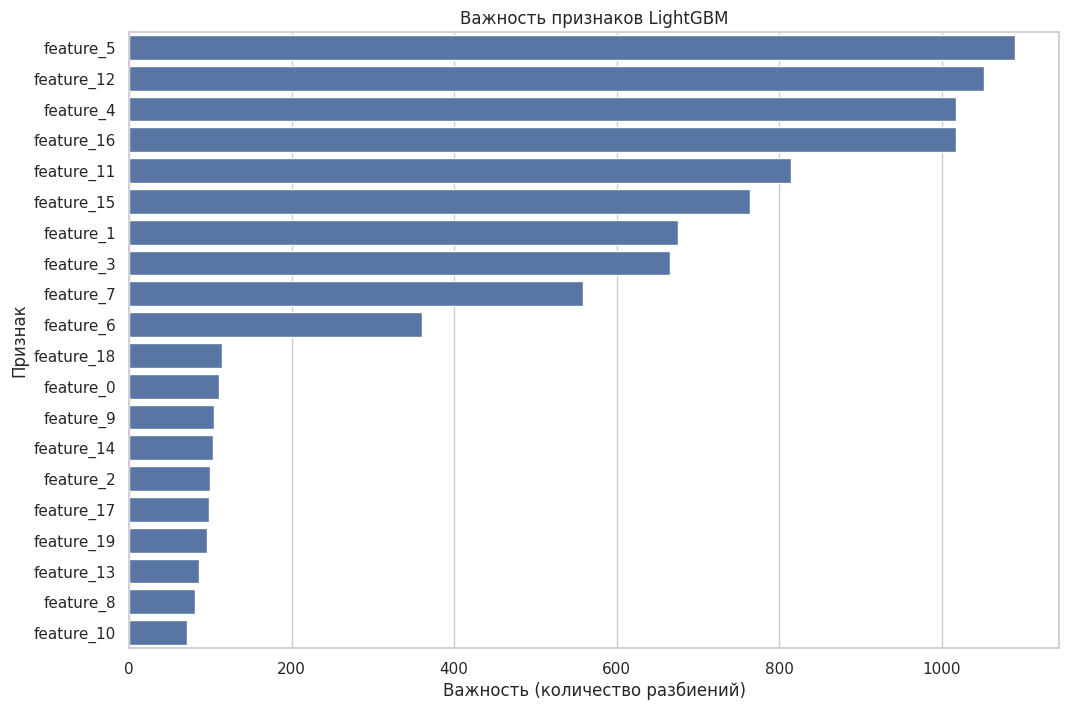

Важности признаков LightGBM:
 feature_5     1090
feature_12    1052
feature_4     1018
feature_16    1018
feature_11     815
feature_15     764
feature_1      675
feature_3      666
feature_7      558
feature_6      361
feature_18     114
feature_0      110
feature_9      105
feature_14     103
feature_2      100
feature_17      98
feature_19      96
feature_13      86
feature_8       81
feature_10      71
dtype: int32


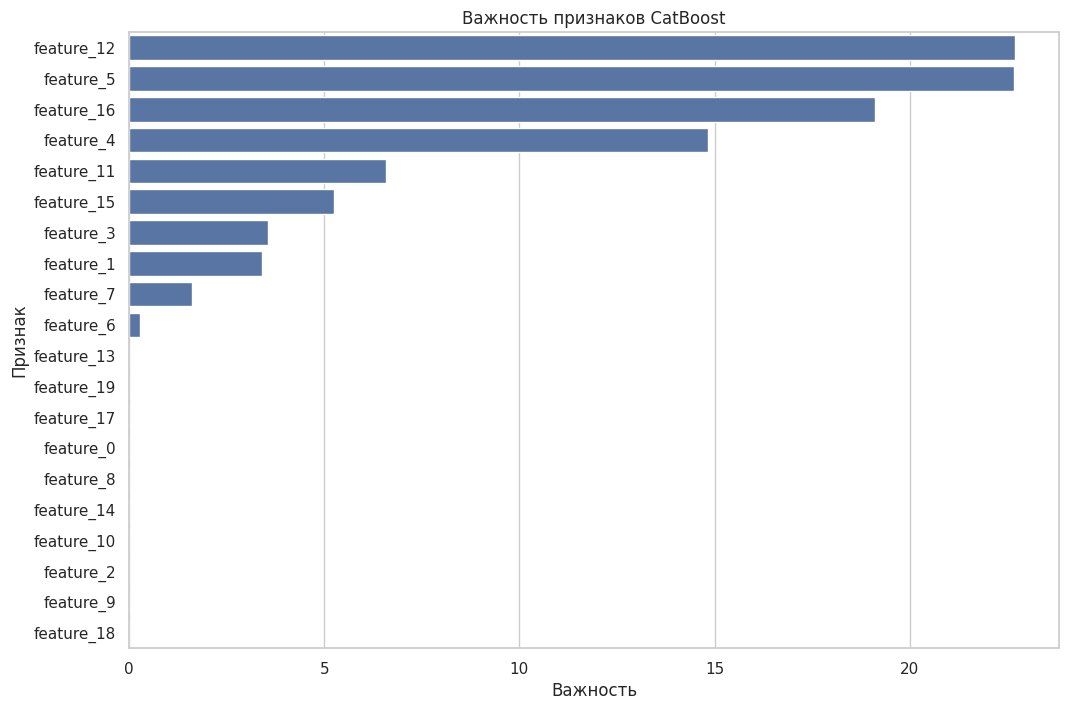


Важности признаков CatBoost:
 feature_12    22.695352
feature_5     22.664060
feature_16    19.114634
feature_4     14.831134
feature_11     6.585274
feature_15     5.254370
feature_3      3.553567
feature_1      3.414931
feature_7      1.608389
feature_6      0.273760
feature_13     0.001268
feature_19     0.001012
feature_17     0.000804
feature_0      0.000488
feature_8      0.000406
feature_14     0.000328
feature_10     0.000223
feature_2      0.000000
feature_9      0.000000
feature_18     0.000000
dtype: float64


In [55]:
# --- 3.1. Важность признаков для LightGBM ---
lgbm_importances = pd.Series(best_lgbm_model.feature_importances_, index=feature_names)
lgbm_importances_sorted = lgbm_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=lgbm_importances_sorted, y=lgbm_importances_sorted.index)
plt.title('Важность признаков LightGBM')
plt.xlabel('Важность (количество разбиений)')
plt.ylabel('Признак')
plt.show()

print("Важности признаков LightGBM:\n", lgbm_importances_sorted)


# --- 3.2. Важность признаков для CatBoost ---
cat_importances = pd.Series(best_cat_model.get_feature_importance(), index=feature_names)
cat_importances_sorted = cat_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=cat_importances_sorted, y=cat_importances_sorted.index)
plt.title('Важность признаков CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

print("\nВажности признаков CatBoost:\n", cat_importances_sorted)
